### In this notebook we continue talk about dataset. Now we'll knows, how we can create a neural network and  train it on MNIST.  And check, how neural network reacts to displacement.
How the inplenet class with neural network you'll see [here](https://github.com/analysiscenter/az_training/blob/anton_broilovskiy/task_02/simple_conv_model.py). And instead writing own batch, using MNIST batch. Implemetation you can see [here](https://github.com/analysiscenter/dataset/blob/master/dataset/opensets/mnist.py). 

In [1]:
import sys

import os
import blosc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('..')
import utils
from my_batch import MnistBatch
from simple_conv_model import ConvModel
from dataset import DatasetIndex, Dataset, V, F, B

On this example we load all the data in memory, and after it we load this data into the Dataset model. But this is not nesessery, you can create dataset and load data at once into batch. Read [this](https://github.com/analysiscenter/dataset/blob/master/doc/batch.md) to more understanding.

In [2]:
src = '../MNIST_data/'
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read()).reshape(-1, 28, 28)
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())

In [3]:
src = (full_imgs, full_labs)

First of all, we need to create [index](https://github.com/analysiscenter/dataset/blob/master/doc/index.md). In our case, the index is a list of indexes, because we know the length of the data set and can iterate on it.

In [4]:
LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

In [5]:
mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

Already familiar to us the construction to create the pipelines. Note, that in this time we have a load function, that load data in batch, but the rest of the design remained the same. This pipelines train NN on simple MNIST images, without shift.

In [6]:
train_normal = (mnistset.train.p
                .load(src)
                .init_variable('shape')
                .update_variable('shape', F(lambda batch: batch.images.shape[1:]))
                .init_model('dynamic',
                            ConvModel,
                            'conv',
                            config={'loss': 'softmax_cross_entropy',
                                    'optimizer':'Adam',
                                    'data_shape': V('shape')})
                .train_model('conv',
                             feed_dict={'input': B('images'),
                                        'targets': B('labels'),
                                        'dropout_rate': 0.4}))

In [7]:
test_normal = (mnistset.test.p
                .import_model('conv', train_normal)
                .load(src)
                .init_variable('predict', init_on_each_run=int)
                .predict_model('conv', 
                             fetches='accuracy',
                             feed_dict={'input': B('images'),
                                        'targets': B('labels'),
                                        'dropout_rate': 0.},
                             save_to=V('predict')))

There are many ways to train pipeline, in this time, we using next_batch. If you want to see all methods, welcome [here](https://github.com/analysiscenter/dataset/blob/master/doc/pipeline.md).

In [8]:
batch_size = 400
for i in tqn(range(1200)):
    train_normal.next_batch(batch_size, n_epochs=None)
    test_normal.next_batch(batch_size, n_epochs=None)

Get variable from pipeline and print accuracy on data without shift

In [9]:
acc = test_normal.get_variable('predict')

print('Accuracy on normal data: ', acc)

Accuracy on normal data:  0.985


Now check, how change accuracy, if we test first model on shift data with parallel computing. In some case operations on data might be very difficult and take a lot of time. To reduce runtime you can use [parallelism](https://github.com/analysiscenter/dataset/blob/master/doc/parallel.md).

In [10]:
shift_pipe = (mnistset.test.p
                .import_model('conv', train_normal)
                .load(src)
                .shift_flattened_pic()
                .init_variable('predict', init_on_each_run=int)
                .predict_model('conv', 
                             fetches='accuracy',
                             feed_dict={'input': B('images'),
                                        'targets': B('labels'),
                                        'dropout_rate': 0.},
                             save_to=V('predict'))
               .run(batch_size, n_epochs=1))

In [11]:
print('Accuracy with shift: ',shift_pipe.get_variable('predict'))

Accuracy with shift:  0.49


In order for the model to be able to predict the augmentation data, we will teach it on such data.

In [12]:
train_shift =  (mnistset.train.p
                .load(src)
                .shift_flattened_pic()
                .init_variable('shape')
                .update_variable('shape', F(lambda batch: batch.images.shape[1:]))
                .init_model('dynamic',
                            ConvModel,
                            'conv',
                            config={'loss': 'softmax_cross_entropy',
                                    'optimizer':'Adam',
                                    'data_shape': V('shape')})
                .train_model('conv',
                             feed_dict={'input': B('images'),
                                        'targets': B('labels'),
                                        'dropout_rate': 0.4}))

In [13]:
for i in tqn(range(1200)):
    train_shift.next_batch(batch_size, n_epochs=None)

Widget Javascript not detected.  It may not be installed or enabled properly.


And now check, how change accuracy on shift data

In [14]:
test_shift = (mnistset.test.p
                .import_model('conv', train_shift)
                .load(src)
                .shift_flattened_pic()
                .init_variable('acc', init_on_each_run=list)
                .init_variable('img', init_on_each_run=list)
                .init_variable('predict', init_on_each_run=list)
                .predict_model('conv', 
                             fetches=['accuracy', 'input', 'labels_hat'],
                             feed_dict={'input': B('images'),
                                        'targets': B('labels'),
                                        'dropout_rate': 0.},
                             append_to=[V('acc'), V('img'), V('predict')])
               .run(1, n_epochs=1))

In [15]:
print('Accuracy with shift: ',np.mean(test_shift.get_variable('acc')))

Accuracy with shift:  0.833077


It's really better, than before.

Iteresting on what numbers we are wrong?

In [16]:
acc = test_shift.get_variable('acc')
img = test_shift.get_variable('img')
predict = test_shift.get_variable('predict')

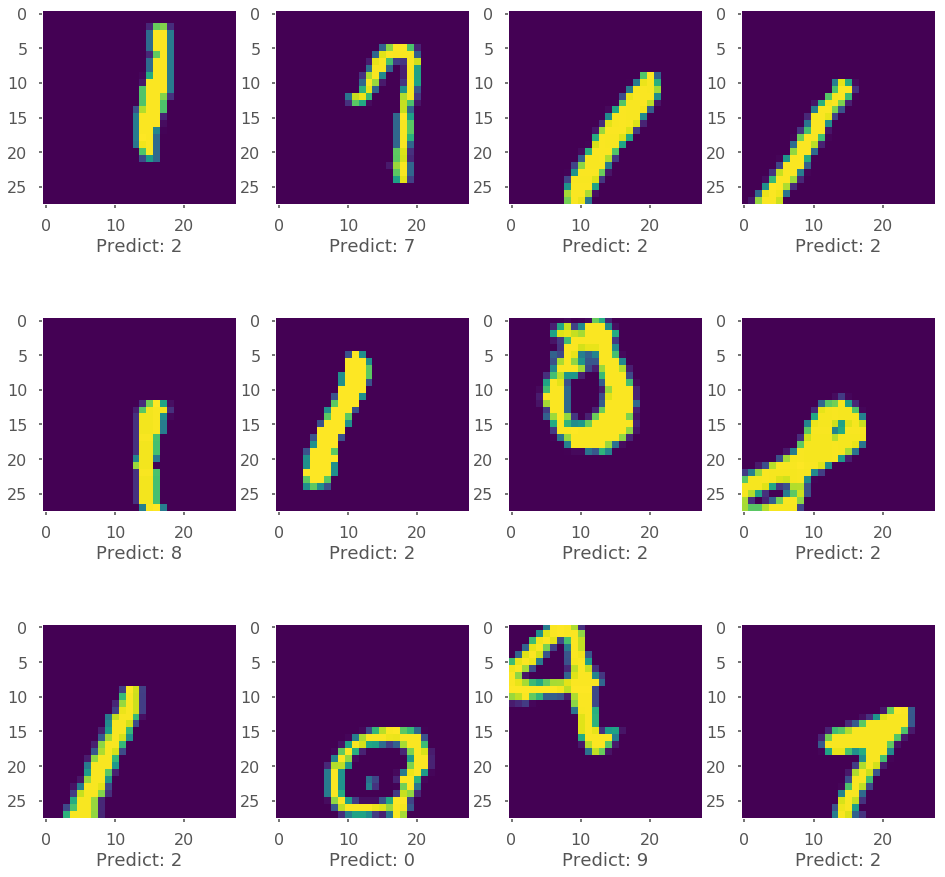

In [17]:
_, ax = plt.subplots(3, 4, figsize=(16, 16))
ax = ax.reshape(-1)
for i in range(12):
    index = np.where(np.array(acc) == 0)[0][i]
    ax[i].imshow(img[index].reshape(-1,28))
    ax[i].set_xlabel('Predict: {}'.format(int(predict[index][0])), fontsize=18)
    ax[i].grid()

In most cases, the model is mistaken for examples in which the figures are heavily shifted, some of them are even hardly recognizable by eye.